In [159]:
import pandas as pd 
from sklearn.neighbors import KNeighborsClassifier as KNN 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np
import os 

os.chdir('../Dataset')
path = os.getcwd()


columns = ['class','l_shoulder','r_shoulder','l_arm','r_arm','l_hip','r_hip','l_knee','r_knee']

y82_test = pd.read_csv(os.path.join(path,'y82_testing.csv'), header=None)
y82_train = pd.read_csv(os.path.join(path,'y82_training.csv'), header=None)
L_test = pd.read_csv(os.path.join(path,'L_testing.csv'), header=None)
L_train = pd.read_csv(os.path.join(path,'L_training.csv'), header=None)

combined_test = pd.concat([L_test, y82_test])
combined_train = pd.concat([L_train, y82_train])

combined_test.columns = columns 
combined_train.columns = columns 

combined_test['class'], classes = pd.factorize(combined_test['class'])
combined_train['class'], _ = pd.factorize(combined_train['class'])

classes = list(classes)


In [160]:
all_combined_df = pd.concat([y82_train, y82_test, L_test, L_train])
all_combined = pd.concat([combined_test, combined_train])

def split_features_labels(df):
    return df.drop('class', axis=1), df['class']

## Using TSNE Reduction to keep the relationships between the datapoints 
# Scrap this, TSNE is an unsupervied method so doesn't really work with TEST and TRAIN datasets, it doens't actually learn a mapping function. Best way to go is PCA 

In [161]:
# from sklearn.manifold import TSNE
# from sklearn.svm import SVC
# X, y = split_features_labels(combined_train)

# tsne = TSNE(n_components = 2)
# X_train_tsne = tsne.fit_transform(X)

# clf = SVC(kernel='linear', probability=True)
# clf.fit(X_train_tsne, y)

In [162]:
# plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y)
# plt.show()

# # create a mesh to plot in
# x_min, x_max = X_train_tsne[:, 0].min() - 1, X_train_tsne[:, 0].max() + 1
# y_min, y_max = X_train_tsne[:, 1].min() - 1, X_train_tsne[:, 1].max() + 1
# xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
#                      np.arange(y_min, y_max, 0.1))

# # Plot the decision boundary
# Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
# Z = Z.reshape(xx.shape)
# plt.contour(xx, yy, Z, cmap=plt.cm.Paired)

# plt.show()

~~Note the use of `.transform` instead of `.fit_transform` when project data (as we did before) as the tsne is using the previously calcualted on the training data to transform the new unseen test data~~


In [163]:
# X_test, y_test = split_features_labels(combined_test)
# X_test_tsne = tsne.transform(X_test)  

# y_pred = clf.predict(X_test)

## Using PCA Reduction, did this first cause this was all I knew. Going to next try to project the data to a higher-dimension to get a fully linearly seperable data

In [164]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

X_train, y_train = split_features_labels(combined_train)
X_test, y_test = split_features_labels(combined_test)

# First Step: Decomp
pca = PCA(n_components = 2)

# Note the use of .transform and .fit_transform 
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


svm = SVC(kernel='rbf', probability=True)
svm.fit(X_train_pca, y_train)

SVC(probability=True)

In [165]:
# # Grid searching best hyper params 
# svm = SVC()

# param_grid = {'C' : [0.1, 1, 10, 100],
#               'gamma' : [0.01, 0.1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
#               'kernel' : ['linear', 'poly'],
#               'coef0' : [-1, 0, 1]}

# # Using grid search cross validation to find the best value of K 
# SVM_GSCV = GridSearchCV(svm, param_grid = param_grid, cv=5)

# '''Shuffle then fit model to data'''
# SVM_GSCV.fit(X_train_pca, y_train)

# SVM_GSCV.best_params_

[('WarriorIII', 0), ('Tree', 1), ('Cobra', 2), ('Chair', 3), ('DownDog', 4)]

              precision    recall  f1-score   support

           0       0.60      0.38      0.46       103
           1       0.97      0.73      0.83       127
           2       0.79      0.97      0.87       188
           3       0.72      0.87      0.79       142
           4       0.94      0.92      0.93       142

    accuracy                           0.81       702
   macro avg       0.80      0.77      0.78       702
weighted avg       0.81      0.81      0.80       702




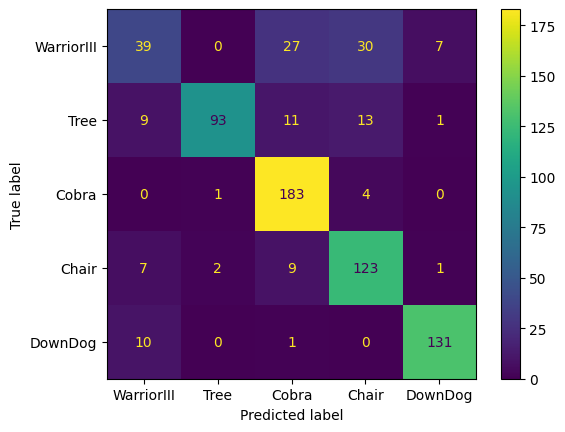

In [166]:
pred = svm.predict(X_test_pca)

cm = confusion_matrix(y_test, pred)
display_confusion_matrix = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
display_confusion_matrix.plot()


print(f'{list(zip(classes, range(5)))}\n')
print(classification_report(y_test, pred))
print()

KeyboardInterrupt: 

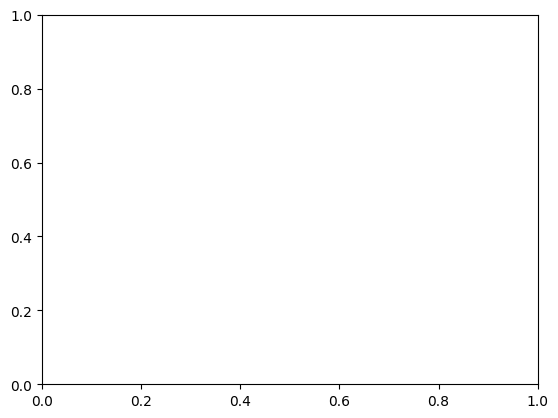

In [167]:
plot_decision_regions(X_test_pca, y_test.to_numpy(), clf=svm, legend=2)

legend = plt.legend(loc='upper right')
for i, t in enumerate(legend.texts):
    t.set_text(classes[i])

plt.xlabel(X_train.columns[0], size=14)
plt.ylabel(X_train.columns[1], size=14)   
plt.title('SVM Decision Region Boundary (After PCA Projection to 2D) [RBF Kernel]', size=16)
plt.show()


# Plotting dimension into higher dimension subspace using RBF Kernel

# 

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from mlxtend.plotting import plot_decision_regions

RANDOM_ORDER_DATA = True 

'''Shuffle data for better resuliting'''
if RANDOM_ORDER_DATA:
    mutated_train = combined_train.sample(frac=1)
else:
    mutated_train = combined_train

X_train, y_train = split_features_labels(mutated_train)
X_test, y_test = split_features_labels(combined_test)

svm = SVC(kernel='rbf')
svm.fit(X_train, y_train)


In [ ]:
pred = svm.predict(X_test)

cm = confusion_matrix(y_test, pred)
display_confusion_matrix = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
display_confusion_matrix.plot()


print(f'{list(zip(classes, range(5)))}\n')
print(classification_report(y_test, pred))
print()

# Projecting data into 2D then using RBF Kernel

In [ ]:
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_train)

# Train an SVM with a radial basis function (RBF) kernel
svm = SVC(kernel='rbf')
svm.fit(X_2d, y_train)
plot_decision_regions(X_2d, y_train.to_numpy(), clf=svm, legend=2)

legend = plt.legend(loc='upper right')
for i, t in enumerate(legend.texts):
    t.set_text(classes[i])

plt.xlabel(X_train.columns[0], size=14)
plt.ylabel(X_train.columns[1], size=14)   
plt.title('SVM Decision Region Boundary (After PCA Projection to 2D) [RBF Kernel]', size=16)
plt.show()


In [ ]:

pred = svm.predict(X_test)

cm = confusion_matrix(y_test, pred)
display_confusion_matrix = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
display_confusion_matrix.plot()


print(f'{list(zip(classes, range(5)))}\n')
print(classification_report(y_test, pred))
print()

## Grid search with all the dimenions, the previous one is just testing 1 dimensions

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# svm.fit(X_train, y_train)

# pred = svm.predict(X_test)

# cm = confusion_matrix(y_test, pred)
# display_confusion_matrix = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
# display_confusion_matrix.plot()

n_features = X_train.shape[1]
gamma_start = 1/X_train.var()[0]

gamma_ranges = [1/i * gamma_start for i in range(1, 10+1)]
### Doing Grid Search Now ###

C_range = [i for i in range(1, 11)]

# set the parameter grid for grid search
param_grid = {
        'C': C_range,
        'gamma' : gamma_ranges
    }

# perform grid search
grid = GridSearchCV(svm, cv=5, param_grid=param_grid, verbose=3)
# grid = RandomizedSearchCV(svm, cv=5, param_distributions=param_grid, verbose=3)
grid.fit(X_train, y_train)

# best parameters and score
print("Best parameters:", grid.best_params_)
print("Best cross-validation score:", grid.best_score_)

# evaluate on test data
y_pred = grid.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test set accuracy:", accuracy)

In [ ]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'


class HyperParameters:

    def __init__(self):
        self.accuracy = float('-inf')
        self.n_comp = -1 
        
        self.model_gamma = -1 
        
        self.kpca_gamma = -1 

        self.model_C = -1

    def __str__(self):
        return f'Best Accuracy: {self.accuracy} | Top Components: {self.n_comp} | Best Model Gamma: {self.model_gamma} | Best Model C: {self.model_C} | Best KPCA Gamma: {self.kpca_gamma}\n'

# Well this seems to be producing the best results, it's still stagnating at around 90ish% though, refuses to get more accurate. Maybe I just need more data

## This was a complete waste of time, the gamme ranges completly fucked me

In [195]:
from sklearn.decomposition import KernelPCA

RANDOM_ORDER_DATA = True 

'''Shuffle data for better resuliting'''
if RANDOM_ORDER_DATA:
    mutated_train = combined_train.sample(frac=1)
else:
    mutated_train = combined_train

X_train, y_train = split_features_labels(mutated_train)
X_test, y_test = split_features_labels(combined_test)

'''This is stupid and made 0 progress

n_features = X_train.shape[1]
epsilon = 0.005
gamma_min = 1 / (n_features*(max(X_train.var())))
gamma_max = 1 / (n_features*(min(X_train.var())))
gamma_ranges = list(np.arange(gamma_min, gamma_max, (max(X_train.var()) - min(X_train.var()))/n_features))
''' 

n_ranges = [i for i in range(n_features, 14)]
C_range = [i for i in range(1, 11)]

# set the parameter grid for grid search
param_grid = {
        'C': C_range,
    }
BestHP = HyperParameters() 

for n_comp in n_ranges:
    kpca = KernelPCA(kernel='rbf', n_jobs=-1, n_components=n_comp, gamma=None)
    X_train_kpca = kpca.fit_transform(X_train)
    X_test_kpca = kpca.transform(X_test)

    # svm = SVC(kernel='rbf', gamma='scale')

    # ''' Using Randomised Search CV instead of GridSearch since it's much faster and the scores are quite near to each other & i'm searching through alot of HP'''
    # grid = RandomizedSearchCV(svm, cv=5, param_distributions=param_grid, n_jobs=-1)
    # grid.fit(X_train_kpca, y_train)

    # print(grid.best_score_)

    # best_model_C = grid.best_params_['C']
    
    best_svm = SVC(kernel='sigmoid', C=10, gamma='scale')
    best_svm.fit(X_train_kpca, y_train)

    # evaluate on test data AFTER transforming
    y_pred = best_svm.predict(X_test_kpca)


    print(X_test_kpca)
    print(accuracy) 

    if accuracy > BestHP.accuracy:
        print(f'{bcolors.OKGREEN}!! New Max Accuracy !!{bcolors.ENDC}: {accuracy} | Old: {BestHP.accuracy}') 
        # print(classification_report(y_test, y_pred))
        BestHP.accuracy = accuracy
        BestHP.n_comp = n_comp
        
        # BestHP.model_C = best_model_C

        print(BestHP)
            
print('='*len(str(BestHP)) + '\n')
print(BestHP)
print('='*len(str(BestHP)))

''' Fitting Final Model'''

final_kpca = KernelPCA(kernel='rbf', n_jobs=-1, n_components=BestHP.n_comp, gamma=None)
X_train_kpca = final_kpca.fit_transform(X_train)
X_test_kpca = final_kpca.transform(X_test)

final_svm = SVC(kernel='rbf', gamma='scale', C=10)
final_svm.fit(X_train_kpca, y_train)

y_pred = final_svm.predict(X_test_kpca)

print('\n\n\n')
print(f'{list(zip(classes, range(5)))}\n')
# print(classification_report(y_test, y_pred))

# cm = confusion_matrix(y_test, y_pred)
# display_confusion_matrix = ConfusionMtrixDisplay(confusion_matrix=cm, display_labels=classes)
# display_confusion_matrix.plot()

[[-0.00047843 -0.00036069 -0.00032231 ... -0.00029483 -0.00031534
  -0.00036106]
 [-0.00047843 -0.00036069 -0.00032231 ... -0.00029483 -0.00031534
  -0.00036106]
 [-0.00047843 -0.00036069 -0.00032231 ... -0.00029483 -0.00031534
  -0.00036106]
 ...
 [-0.00047843 -0.00036069 -0.00032231 ... -0.00029483 -0.00031534
  -0.00036106]
 [-0.00047843 -0.00036069 -0.00032231 ... -0.00029483 -0.00031534
  -0.00036106]
 [-0.00047843 -0.00036069 -0.00032231 ... -0.00029483 -0.00031534
  -0.00036106]]
0.2022792022792023
!! New Max Accuracy !!: 0.2022792022792023 | Old: -inf
Best Accuracy: 0.2022792022792023 | Top Components: 8 | Best Model Gamma: -1 | Best Model C: -1 | Best KPCA Gamma: -1

[[-0.00047843 -0.00036069 -0.00032231 ... -0.00031534 -0.00036106
  -0.00022925]
 [-0.00047843 -0.00036069 -0.00032231 ... -0.00031534 -0.00036106
  -0.00022925]
 [-0.00047843 -0.00036069 -0.00032231 ... -0.00031534 -0.00036106
  -0.00022925]
 ...
 [-0.00047843 -0.00036069 -0.00032231 ... -0.00031534 -0.00036106
 

In [ ]:
match = [f'Real: {x[0]} Pred: {x[1]}' for x in zip(y_test, y_pred)]
y_bad = [1 for _ in range(len(y_test))]
print(classification_report(y_test, pred))
print(classification_report(y_bad, pred))

# This is just some testing / debugging suite

In [187]:
RANDOM_ORDER_DATA = False 

'''Shuffle data for better resuliting'''
if RANDOM_ORDER_DATA:
    mutated_train = combined_train.sample(frac=1)
    mutated_test = combined_test.sample(frac=1)
else:
    mutated_train = combined_train
    mutated_test = combined_test

X_train, y_train = split_features_labels(mutated_train)
X_test, y_test = split_features_labels(combined_test)

''' Using Randomised Search CV instead of GridSearch since it's much faster and the scores are quite near to each other & i'm searching through alot of HP'''

def RandomSearchSVM_ypred():
    n_features = X_train.shape[1]
    gamma_start = 1/X_train.var()[0]

    gamma_ranges = [1/i * gamma_start for i in range(1, 10+1)]
    C_range = [i for i in range(1, 11)]

    # set the parameter grid for grid search
    param_grid = {
            'C': C_range,
            'gamma' : gamma_ranges
        }

    svm = SVC(kernel='rbf')

    grid = RandomizedSearchCV(svm, cv=5, param_distributions=param_grid, n_jobs=-1)
    grid.fit(X_train, y_train)

    best_svm = SVC(kernel='rbf', C=grid.best_params_['C'], gamma=grid.best_params_['gamma']) # From Search
    best_svm.fit(X_train, y_train)

    y_pred = best_svm.predict(X_test)
    return y_pred


''' From testing these were pretty good values'''
def HardCodedSVM_ypred():
    final_kpca = KernelPCA(kernel='rbf', n_jobs=-1, n_components=9, gamma=4.073013044517308e-05)
    X_train_kpca = final_kpca.fit_transform(X_train)
    X_test_kpca = final_kpca.transform(X_test)

    final_svm = SVC(kernel='rbf', gamma=2.036506522258654e-05, C=3)
    final_svm.fit(X_train_kpca, y_train)

    y_pred_good = final_svm.predict(X_test_kpca)

    return y_pred_good

def BadSVM():
    best_svm = SVC(kernel='rbf', C=1000, gamma=1000) # Hard Code Bad Values
    return best_svm


# y_pred_hard = HardCodedSVM_ypred()
y_pred_search = RandomSearchSVM_ypred()

print('\n\n\n')
print(f'{list(zip(classes, range(5)))}\n')
print(classification_report(y_test, y_pred_search))





[('WarriorIII', 0), ('Tree', 1), ('Cobra', 2), ('Chair', 3), ('DownDog', 4)]

              precision    recall  f1-score   support

           0       0.83      0.62      0.71       103
           1       0.93      0.97      0.95       127
           2       0.90      0.95      0.92       188
           3       0.87      0.90      0.89       142
           4       0.95      0.98      0.97       142

    accuracy                           0.90       702
   macro avg       0.90      0.88      0.89       702
weighted avg       0.90      0.90      0.90       702

